# Rethinking Credit Card Approval Prediction

![image.png](attachment:a63c8981-d14d-4a12-974c-76dff6e28440.png)

**Credit Card Default prediction is an important problem for both banks and credit card providers, like Mastercard, Visa and American Express. Because it’s essential for reducing financial losses for both stakeholders, to maintain stability, and optimizing risk-based pricing. Achieving a better model will also help credit card companies refine their customer segmentation, because both problems have imbalanced datasets. It will help improve risk-analysis when deciding which applications to approve, so as to focus their capital on profitable applications and reduce losses. It will set better credit limits, and minimize fraud-related losses, and time their charge-offs better, to minimize risk in business.**

**It is also an interesting problem, because its datasets are usually imbalanced (T. M. Alam et al., 2020), so the model should be evaluated differently, to avoid mistaking a lazy machine learning model with an accuracy of 95% as excellent, when the test dataset itself has defaulters representing only 7% of the data.**

**The new contribution - what this project will do differently:**

My project aims to combine the approaches followed by the 3 papers, in the
literature review:
1. It will use the techniques utilized by the first paper, to balance the training data,
but without the data leak risks it had, such as min-max normalization before
splitting the dataset, and under/over-sampling before splitting the dataset as well.
2. The model will also be explainable by using SHAP (SHapley Additive
Explanations) values, to show the importance of each feature, when making a
prediction, or alternatively apply LIME (Local Interpretable Model-Agnostic
Explanations).
3. Similarly, to the third research paper, it will use ensemble learning, to combine
the best machine learning models, for this dataset, into one. However, this paper
will aim to use a better set of models, and choose the best combination using Grid Search and cross-validation (to optimize accuracy, rather than guessing
hyperparameters).
4. It will also have outlier detection, and Dynamic Feature Updates, to keep the
model autonomous, by re-training itself, using online data, to avoid becoming
outdated. However, it will do this differently, by using Recursive Feature
Elimination (RFE) to remove irrelevant or redundant features.

Lastly, this project will examine if alternative evaluation methods would be better
suited for default prediction, better than Precision and Recall, F1-Score, and the
AUC-ROC curve. Because using the right evaluation method is critical to quantifying
improvements, to a model that already predicts a highly imbalanced dataset. This can
also span improvements in medicine, where the percentage of true positive test cases
may be very low.

An improvement in Default Prediction, using Machine Learning, can help guide if
Deep Learning is needed to reach better outcomes, and help credit card providers,
banks and hospitals utilize machine learning in their daily operations, more productively.
For example, handling imbalanced datasets is common when trying to predict cancer in
its early stages, which means that solving this problem better, spans domains beyond
fintech, for a better society.

In [2]:
#First import the needed libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler, Binarizer, OneHotEncoder, OrdinalEncoder, MinMaxScaler
#oneHotencoder is for variables that are not ordinal
#OrdinalEcondor is for ordinal variables

from scipy.stats import pearsonr, spearmanr, chi2_contingency, pointbiserialr, f_oneway
from sklearn.impute import SimpleImputer

#Also, these libraries so as to apply k-means SMOTE
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans


In [3]:
pd.set_option('display.max_columns', None) #forces pandas display all columns in a dataframe
pd.set_option('display.max_rows', None) #forces pandas to display all rows
#The second argument is None, because we want to set no limit as to how many values to display

In [4]:
application_record = pd.read_csv('/kaggle/input/application_record.csv')
credit_record = pd.read_csv('/kaggle/input/credit_record.csv')

In [5]:
#Inspect the features available in the application records dataset
application_record.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [6]:
#Inspect the features available in the credit records dataset
credit_record.head()

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [7]:
print('The shape of the application_record dataset is', application_record.shape)
print('The shape of the credit_record dataset is', credit_record.shape)

#Now I need to count the number of unique ID's present in both datasets:

#These 2 lines will put all ID's from each dataset in a set, to ensure only unique values are taken
unique_ids_application = set(application_record["ID"])
unique_ids_credit = set(credit_record["ID"])

#Count the intersection of both sets
unique_ids_in_both = len(unique_ids_application.intersection(unique_ids_credit))
print("Number of unique ID's present in both datasets:", unique_ids_in_both)

#Now, I need the number of ID's that are not in both datasets, to decide if I should impute their status
#Or fully drop these ID's

# This will create sets of the ID's that are only in one of the datasets (not in both)
ids_only_in_application = unique_ids_application - unique_ids_credit
ids_only_in_credit = unique_ids_credit - unique_ids_application

# Total number of IDs not present in both sets
unique_ids_not_in_both = len(ids_only_in_application) + len(ids_only_in_credit)

print("Number of ID's that are not present in both datasets:", unique_ids_not_in_both)

The shape of the application_record dataset is (438557, 18)
The shape of the credit_record dataset is (1048575, 3)
Number of unique ID's present in both datasets: 36457
Number of ID's that are not present in both datasets: 411581


I wouldn't be able to impute the features of the missing ID's without potentially introducing some bias, and a data leak as well, so I have decided to drop them

In [8]:
#Now, merge both datasets, so that the status can be connected to the applicant, then inspect it
merged_records = pd.merge(application_record, credit_record, on="ID", how="inner")
#how = "inner" is so that we drop ID's not present in both datasets
#on = "ID" is so that we merge by the ID

merged_records.head(10)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-4,C
5,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-5,C
6,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-6,C
7,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-7,C
8,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-8,C
9,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,-9,C


This shows that the 2 datasets were merged correctly

Let me however check its shape to test that it's the same as the number of unique ID's we had, 36,457

In [9]:
merged_records.shape

(777715, 20)

We have 777,715 rows. We need to check the number of unique ID's compared to the shape of each dataset

In [10]:
print("The number of records in application_records is: ", application_record.shape[0])
print("The number of unique ID's in application_records is: ", application_record['ID'].nunique())
print("The number of records in credit_records is: ", credit_record.shape[0])
print("The number of unique ID's in credit_records is: ", credit_record['ID'].nunique())

The number of records in application_records is:  438557
The number of unique ID's in application_records is:  438510
The number of records in credit_records is:  1048575
The number of unique ID's in credit_records is:  45985


It seems that some ID's are duplicated in both datasets, which then explains the mis-allignment between 777,715 and 36,457

The number of duplicate ID's in application records is 438557 - 438510 = 47. Since, I am not sure which records to keep, out of the duplicate ID's, I will just drop any records which have duplicates, along with their duplicates as well. This is not a huge loss, because it should be at most 47 * 2 = 94 records, whereas, we would still have 438,463 application records at least.

In [11]:
# Mark all duplicates (keep=False) and the indexing then keeps only the rows which are not marked
application_record = application_record[application_record.duplicated('ID', keep=False) == False]

As for credit records, the number of unique ID's is much smaller than the number of credit records (45,985 compared to 1,048,575). Upon inspecting the dataset closer, I understood that it's a time series dataset. So I have decided to merge MONTHS_BALANCE and STATUS into multiple features, whereas the key would be the month (0, -1, -2, -3, etc.) and the value would be the status.

**The target value we are trying to predict would then be the status in month 0 (current month), to predict which applicants are likely to pay their loans this month {C}, miss their payment {0,1,2,3,4,5} , or not take out any loans {X}. This also makes the problem more interesting, so that the features of each status doesn't mix up into one forced category. It would help to quantitatively assess the risk of approving a candidate's credit card application.**

In [12]:
#Now, I will merge both datasets properly, unlike last time

# Pivot the credit records dataframe to make MONTHS_BALANCE values as column names
credit_pivot = credit_record.pivot(index="ID", columns="MONTHS_BALANCE", values="STATUS")

#Reset the ID index, into a column again
credit_pivot = credit_pivot.reset_index()

#Now, merge both datasets, on ID, while dropping any ID's not present in both
merged_records = pd.merge(application_record, credit_pivot, on="ID", how="inner")
merged_records.head(5)

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,0
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,1,C,C,C,C,C,C,C,C,C,C,C,C,C
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,1,C,C,C,C,C,C,C,C,C,C,C,C
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,X,X,X,0,X,X,X,0,X,X,X,X,X,X,0,X,0,X,0,0,X,C,C,C,C,C,C,C
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,0,X,0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,X,X,X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
#Inspect the dataset quickly
print('Data Types in the Dataset:\n', merged_records.dtypes)

Data Types in the Dataset:
 ID                       int64
CODE_GENDER             object
FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_MOBIL               int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
OCCUPATION_TYPE         object
CNT_FAM_MEMBERS        float64
-60                     object
-59                     object
-58                     object
-57                     object
-56                     object
-55                     object
-54                     object
-53                     object
-52                     object
-51                     object
-50                     object
-49                     object
-48                     object
-47        

In [14]:
#Get general stats on the dataset
merged_records.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS
count,3.645700e+04,36457.000000,3.645700e+04,36457.000000,36457.000000,36457.0,36457.000000,36457.000000,36457.000000,36457.000000
mean,5.078227e+06,0.430315,1.866857e+05,-15975.173382,59262.935568,1.0,0.225526,0.294813,0.089722,2.198453
std,4.187524e+04,0.742367,1.017892e+05,4200.549944,137651.334859,0.0,0.417934,0.455965,0.285787,0.911686
min,5.008804e+06,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000
25%,5.042028e+06,0.000000,1.215000e+05,-19438.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000
50%,5.074614e+06,0.000000,1.575000e+05,-15563.000000,-1552.000000,1.0,0.000000,0.000000,0.000000,2.000000
75%,5.115396e+06,1.000000,2.250000e+05,-12462.000000,-408.000000,1.0,0.000000,1.000000,0.000000,3.000000
max,5.150487e+06,19.000000,1.575000e+06,-7489.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000


After taking a quick look, it seems that some values may be the same across every row. This is useful to know, so as to help us know which features to exclude. My next step is to know how many unique values are in each columnn/feature

In [15]:
merged_records.nunique()

ID                     36457
CODE_GENDER                2
FLAG_OWN_CAR               2
FLAG_OWN_REALTY            2
CNT_CHILDREN               9
AMT_INCOME_TOTAL         265
NAME_INCOME_TYPE           5
NAME_EDUCATION_TYPE        5
NAME_FAMILY_STATUS         5
NAME_HOUSING_TYPE          6
DAYS_BIRTH              7183
DAYS_EMPLOYED           3640
FLAG_MOBIL                 1
FLAG_WORK_PHONE            2
FLAG_PHONE                 2
FLAG_EMAIL                 2
OCCUPATION_TYPE           18
CNT_FAM_MEMBERS           10
-60                        3
-59                        4
-58                        4
-57                        4
-56                        5
-55                        6
-54                        7
-53                        6
-52                        7
-51                        7
-50                        7
-49                        8
-48                        8
-47                        8
-46                        8
-45                        8
-44           

FLAG_MOBIL should be excluded, because it's the same for every ID, so it's meaningless.

Also, the ID's don't provide any inferences, and should be dropped to avoid overfitting the model to the data.

Gender should also be dropped, to avoid systematic discrimination. It's not ethical.

In [16]:
#Dropping the ID, FLAG_MOBIL, CODE_GENDER columns
merged_records.drop(['ID', 'FLAG_MOBIL', 'CODE_GENDER'], axis=1, inplace=True)

Next, I need to deal with one problem. What about the ID's that have -1 (a missing status) in the current month (month 0) ?

Imputing their value would cause a data leak, because we would be creating the target variable, for the testing data, using the training data. Hence, I should drop these ID's

In [17]:
print("The number of ID's available before dropping any rows where the target variable is missing: ", merged_records.shape[0])
merged_records = merged_records.dropna(subset=[0])
print("The number of ID's available before dropping any rows where the target variable is missing: ", merged_records.shape[0])

The number of ID's available before dropping any rows where the target variable is missing:  36457
The number of ID's available before dropping any rows where the target variable is missing:  24672


Now I need to roughly see the distribution of the statuses in column 0 (current month)

In [18]:
# Calculate absolute and relative distribution for column '0'
status_counts = merged_records[0].value_counts()
status_relative = merged_records[0].value_counts(normalize=True) * 100

print('status counts:\n', status_counts)
print('status proportions:\n', status_relative)

status counts:
 0
C    12974
0     6886
X     4487
1      236
5       59
2       19
3        6
4        5
Name: count, dtype: int64
status proportions:
 0
C    52.585927
0    27.910182
X    18.186608
1     0.956550
5     0.239137
2     0.077010
3     0.024319
4     0.020266
Name: proportion, dtype: float64


Given how highly imbalanced the dataset is, we will have to balance it before training the ML model

But before balancing it, I need to check how many missing values there are in each column, and impute them if any, so that SMOTE (for balancing the dataset) would work correctly

In [19]:
# Check for missing values in each feature, and get their total
missing_values = merged_records.isnull().sum()

# Display the missing values count
print(missing_values)

FLAG_OWN_CAR               0
FLAG_OWN_REALTY            0
CNT_CHILDREN               0
AMT_INCOME_TOTAL           0
NAME_INCOME_TYPE           0
NAME_EDUCATION_TYPE        0
NAME_FAMILY_STATUS         0
NAME_HOUSING_TYPE          0
DAYS_BIRTH                 0
DAYS_EMPLOYED              0
FLAG_WORK_PHONE            0
FLAG_PHONE                 0
FLAG_EMAIL                 0
OCCUPATION_TYPE         7629
CNT_FAM_MEMBERS            0
-60                    24544
-59                    24409
-58                    24276
-57                    24146
-56                    23991
-55                    23834
-54                    23694
-53                    23530
-52                    23325
-51                    23113
-50                    22892
-49                    22699
-48                    22454
-47                    22231
-46                    22012
-45                    21801
-44                    21566
-43                    21301
-42                    21053
-41           

It appears that I am missing values in the OCCUPATION_TYPE and in the months columns.

Missing values in OCCUPATION_TYPE could be reasonably imputed, after exploring it

However, missing values in the months columns may indicate that the applicant did not have a credit card by then. And hence, imputing these values may incorrectly bias the prediction model. A client that had lesser experience using a credit card should not be equally evaluated as one with more experience.

Values may also be missing, due to missing data.

How could I check for these conditions ?

I will create a function that should print the ID of any client that has a NaN recorded in a month AFTER their first recorded status. That way, I can identify if there are missing status entries OR if the missing entries imply that the client didn't have a credit card back then.

In [20]:
def find_clients_with_missing_after_first(df, id_column):
    """
    Identifies and prints the IDs of clients who have missing values after their first recorded status entry.

    Parameters:
    df (pd.DataFrame): The dataset containing client credit history.
    id_column (str): The name of the column that uniquely identifies each client.
    """
    # Selecting only the columns related to monthly credit history (-60 to 0)
    #This does that, by removing any leading '-' then checking if the string is a digit
    df.columns = df.columns.astype(str) #Setting the columns' datatypes to strings, just to make implementation easier
    months_cols = [col for col in df.columns if col.lstrip('-').isdigit()]

    # List to store client IDs with missing values after their first recorded status
    clients_with_missing_after_first = []

    # Iterate through each row
    #df.iterrows allows you to iterate over the rows of a DataFrame as (index, Series) pairs.
    for index, row in df.iterrows():
        #indexing by column names gives a sliced series of only the values under those column names.
        #And then .first_valid_index() would return the index for the first non-NaN value, other None
        first_valid_index = row[months_cols].first_valid_index()
        if first_valid_index is not None:
            # Check if there are missing values after the first recorded status
            if row[first_valid_index:].isnull().sum() > 0:
                clients_with_missing_after_first.append(row[id_column])

    # Print results
    if len(clients_with_missing_after_first) > 0:
        print("Clients with missing values after their first recorded status entry:")
        for client_id in clients_with_missing_after_first:
            print(client_id)
    else:
        print("No clients have missing values after their first recorded status entry.")

# Run the function on the dataset
find_clients_with_missing_after_first(merged_records, 'ID')

No clients have missing values after their first recorded status entry.


Great, now I can be sure that any NaN entry in the months' columns simply means that the client didn't have a credit card back then, rather than it being a missing entry

The next step now, is to impute OCCUPATION_TYPE. First I want to view the different categories in it

In [21]:
print(merged_records['OCCUPATION_TYPE'].unique())

[nan 'Security staff' 'Sales staff' 'Accountants' 'Laborers' 'Managers'
 'Drivers' 'Core staff' 'High skill tech staff' 'Cleaning staff'
 'Private service staff' 'Cooking staff' 'Low-skill Laborers'
 'Medicine staff' 'Secretaries' 'Waiters/barmen staff' 'HR staff'
 'Realty agents' 'IT staff']


Looking at the categories, I can identify that they are nominal categorical features. The common methods of imputing it are by imputing the mode or randomly imputing existing values.

Before choosing a method, I want to decide if it's a feature worth keeping, or if it's more likely to bias my model, if it was mostly imputed. If its missing values are more than 5%, then I will drop this feature.

In [22]:
( merged_records['OCCUPATION_TYPE'].isna().sum() * 100 ) / len(merged_records)

30.92169260700389

In [23]:
#30.9% > 5%, hence I will drop this feature to avoid biasing my prediction model
merged_records.drop(['OCCUPATION_TYPE'], axis=1, inplace=True)

Now, it's time to visualize the data. In order to create meaningful visualizations, we need to separate the data by categories (numerical vs categorical) and separate the categorical data by sub-categories (ordinal vs nominal), and the numerical data by sub-categories (discrete vs continuous), as it can help make educated choices about which visualizations to choose, rather than discovering by trial and error

In [24]:
#First, I need to inspect the datatype of each column again
print(merged_records.dtypes)

FLAG_OWN_CAR            object
FLAG_OWN_REALTY         object
CNT_CHILDREN             int64
AMT_INCOME_TOTAL       float64
NAME_INCOME_TYPE        object
NAME_EDUCATION_TYPE     object
NAME_FAMILY_STATUS      object
NAME_HOUSING_TYPE       object
DAYS_BIRTH               int64
DAYS_EMPLOYED            int64
FLAG_WORK_PHONE          int64
FLAG_PHONE               int64
FLAG_EMAIL               int64
CNT_FAM_MEMBERS        float64
-60                     object
-59                     object
-58                     object
-57                     object
-56                     object
-55                     object
-54                     object
-53                     object
-52                     object
-51                     object
-50                     object
-49                     object
-48                     object
-47                     object
-46                     object
-45                     object
-44                     object
-43                     object
-42     

In [25]:
#I need to ensure that any column that's meant to hold strings, has the string data type
#rather than the object data type, which could mean mixed data types
merged_records['FLAG_OWN_CAR'] = merged_records['FLAG_OWN_CAR'].astype('string')
merged_records['FLAG_OWN_REALTY'] = merged_records['FLAG_OWN_REALTY'].astype('string')
merged_records['NAME_INCOME_TYPE'] = merged_records['NAME_INCOME_TYPE'].astype('string')
merged_records['NAME_EDUCATION_TYPE'] = merged_records['NAME_EDUCATION_TYPE'].astype('string')
merged_records['NAME_FAMILY_STATUS'] = merged_records['NAME_FAMILY_STATUS'].astype('string')
merged_records['NAME_HOUSING_TYPE'] = merged_records['NAME_HOUSING_TYPE'].astype('string')
merged_records['0'] = merged_records['0'].astype('string')

#Also, rename column 0, as the target variable (Current Status)
merged_records = merged_records.rename(columns={'0': 'Current Status'})

I will combine all categorical features, along with the status into a new dataframe

In [26]:
categorical_features = merged_records[['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE', 'FLAG_WORK_PHONE', 'FLAG_PHONE', 'FLAG_EMAIL', 'Current Status']].copy()

categorical_features.head()
categorical_features.to_csv('categorical_features.csv', index=False)

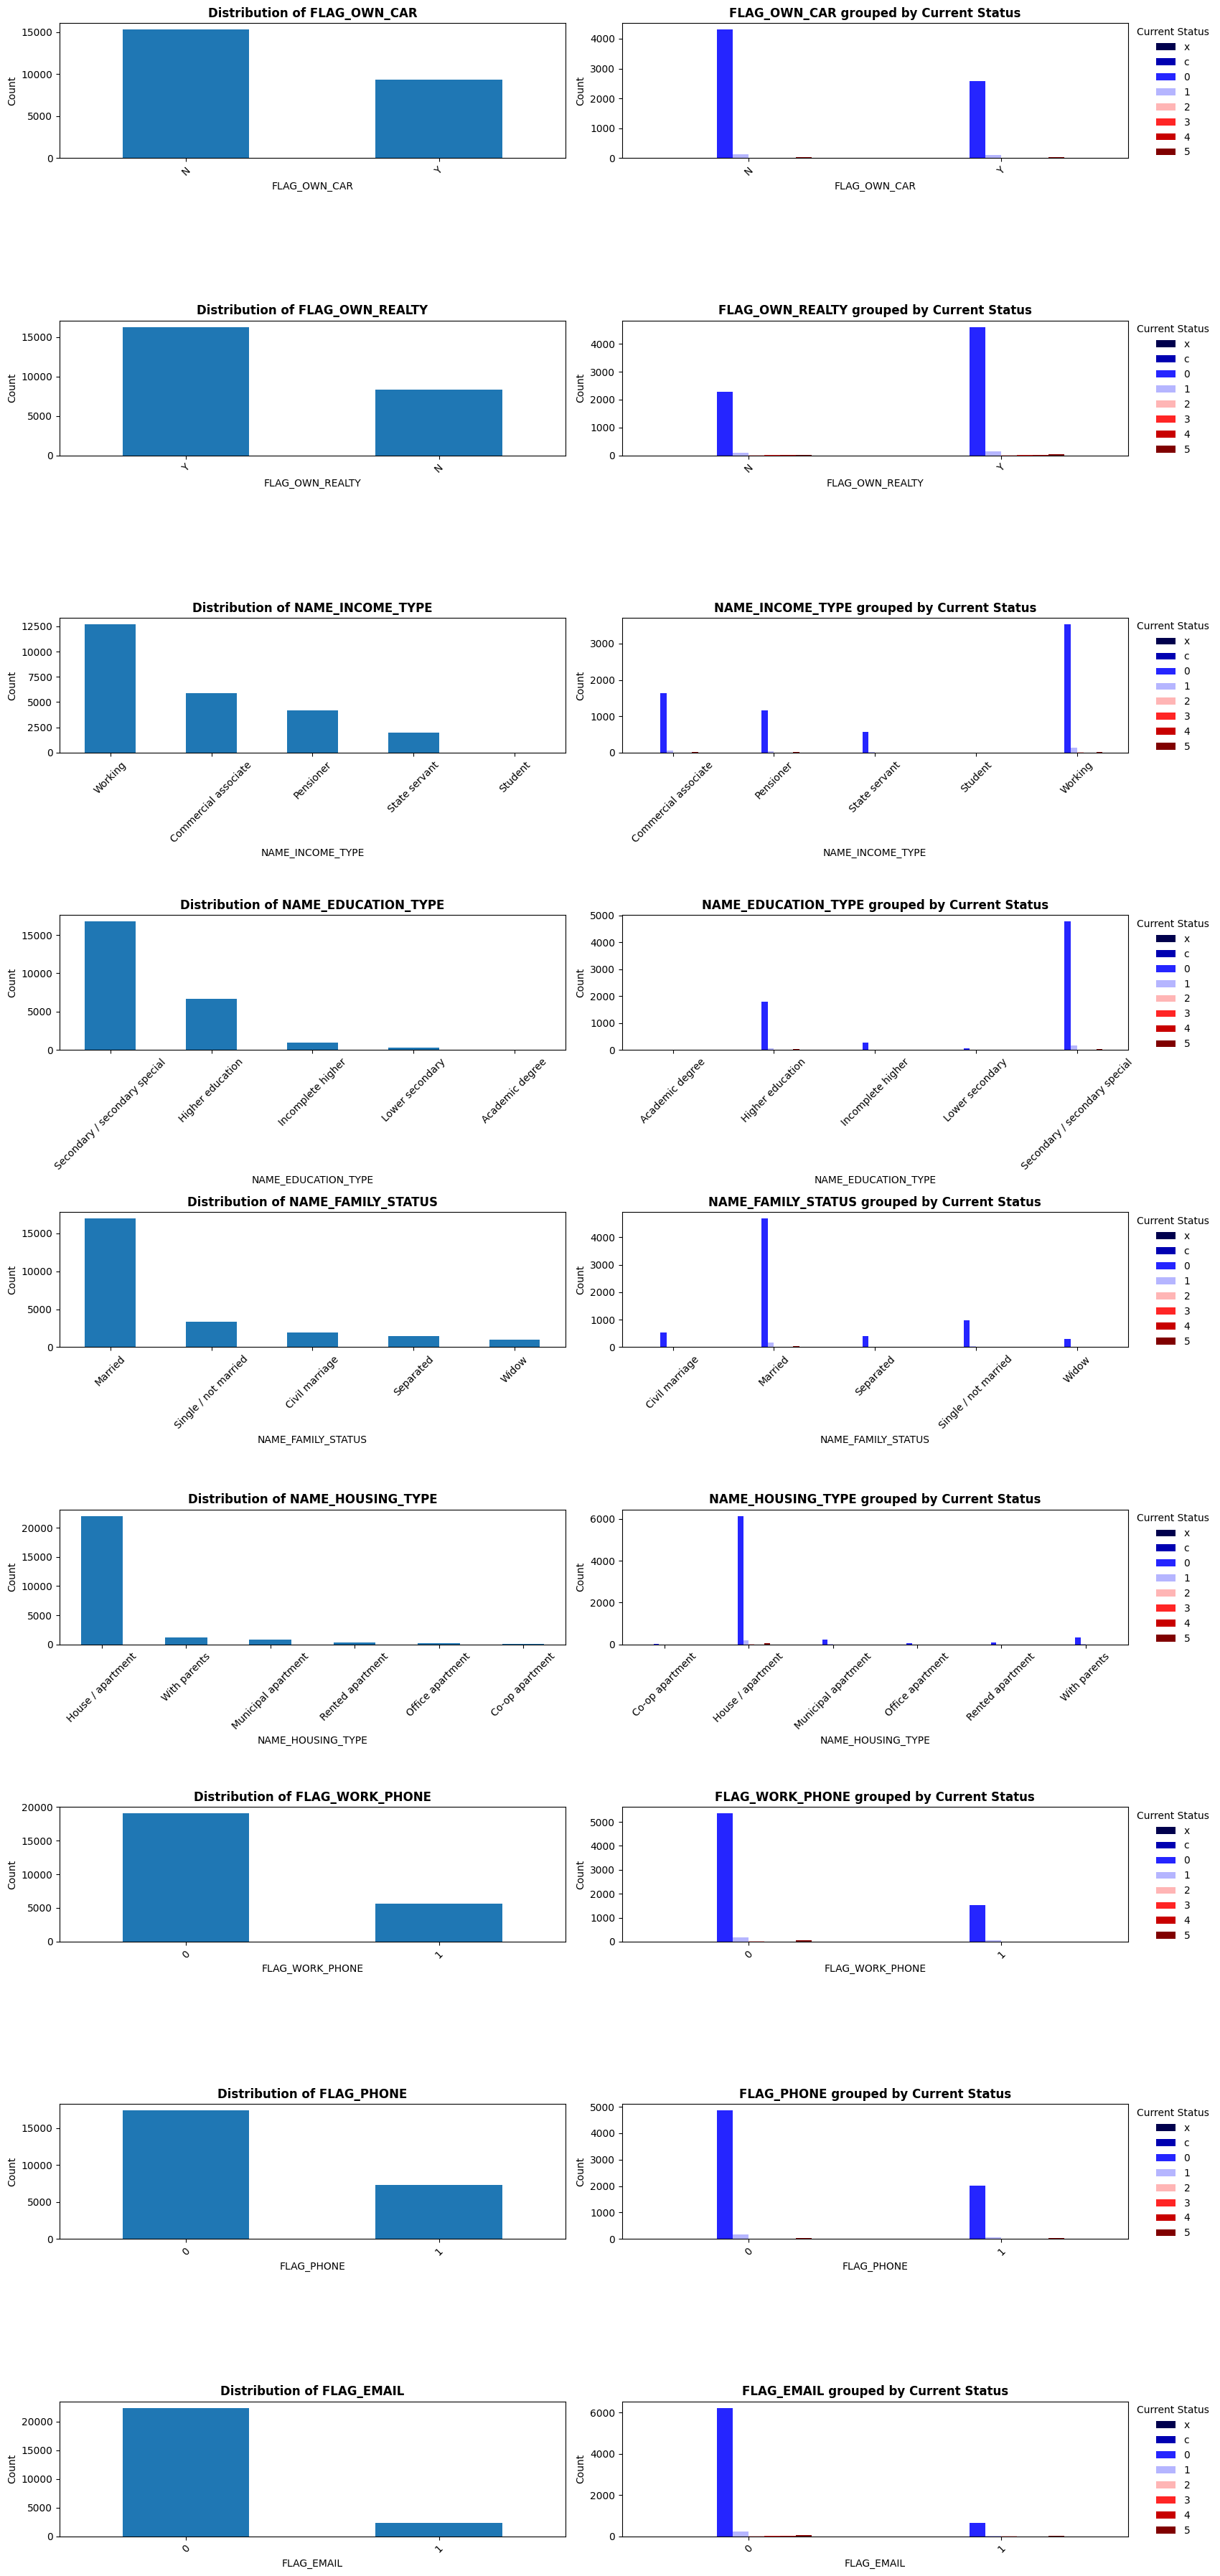

In [27]:
#Now generate pair plots, of bar charts, to see the corrlations inbetween the
#categorical features and the current status

# Define feature columns and target
feature_cols = [col for col in categorical_features.columns if col != 'Current Status']
target_col = 'Current Status'
num_features = len(feature_cols)

# Define custom class order
status_order = ['x', 'c', '0', '1', '2', '3', '4', '5']

# Use seismic colormap and map to the 8-class order
seismic_cmap = plt.colormaps.get_cmap('seismic')
colors = seismic_cmap(np.linspace(0, 1, len(status_order)))
color_map = dict(zip(status_order, colors))

# Create subplots
fig, axes = plt.subplots(nrows=num_features, ncols=2, figsize=(18, 4 * num_features))

for i, col in enumerate(feature_cols):
    # Left: Raw value counts
    categorical_features[col].value_counts().plot(kind='bar', ax=axes[i][0])
    axes[i][0].set_title(f'Distribution of {col}', fontweight='bold')
    axes[i][0].set_xlabel(col)
    axes[i][0].set_ylabel('Count')
    axes[i][0].tick_params(axis='x', rotation=45)

    # Right: Grouped by 'Current Status'
    grouped = categorical_features.groupby([col, target_col]).size().unstack(fill_value=0)

    # Ensure all target categories are present
    for label in status_order:
        if label not in grouped.columns:
            grouped[label] = 0
    grouped = grouped[status_order]  # reorder columns

    # Apply colors
    color_list = [color_map[s] for s in grouped.columns]

    grouped.plot(kind='bar', ax=axes[i][1], color=color_list)
    axes[i][1].set_title(f'{col} grouped by {target_col}', fontweight='bold')
    axes[i][1].set_xlabel(col)
    axes[i][1].set_ylabel('Count')
    axes[i][1].tick_params(axis='x', rotation=45)

    # Legend outside top-right
    axes[i][1].legend(
        title=target_col,
        loc='upper left',
        bbox_to_anchor=(1.01, 1),
        borderaxespad=0,
        frameon=False
    )

plt.tight_layout(rect=[0, 0, 0.95, 1])  # Leave space for legends
plt.savefig("categorical_bar_charts.svg", format="svg", bbox_inches="tight")
plt.show()


I can see from this visualization that the dataset is highly imbalanced, so it's just very hard to view any correlations.
Let's try a heat map, to show correlations instead, since counts doesn't feel very meaningful, with an imbalanced dataset

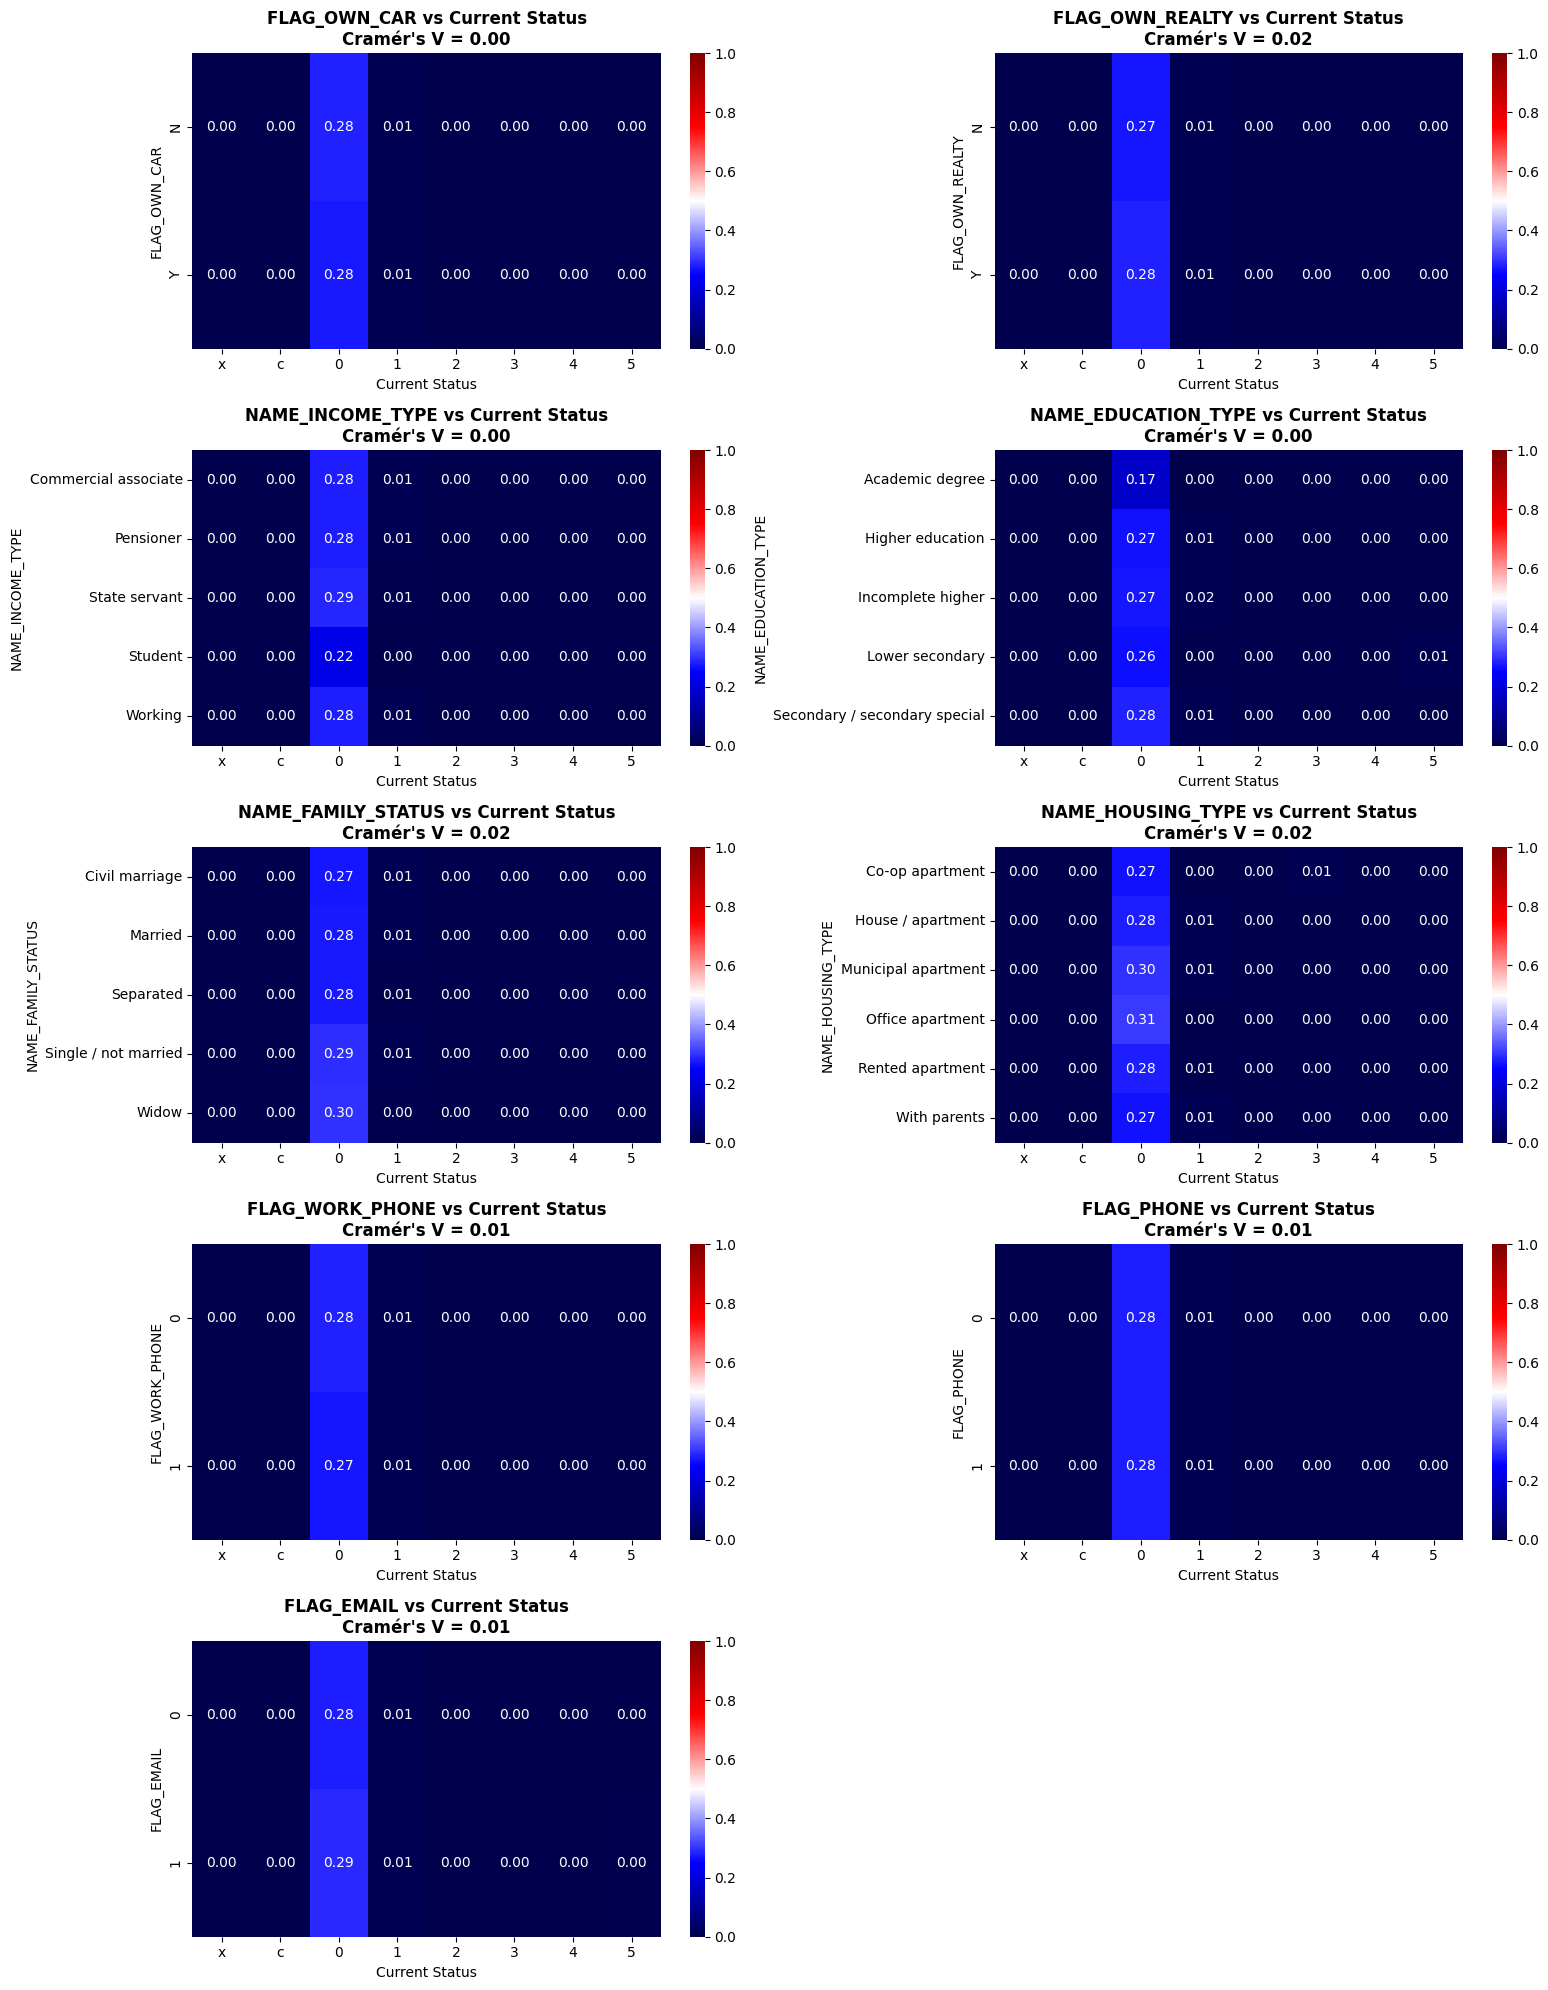

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Compute Cramér's V statistic for two categorical vectors."""
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))  # bias correction
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Assume DataFrame is already loaded and '0' is renamed to 'Current Status'
feature_cols = [col for col in categorical_features.columns if col != 'Current Status']
target_col = 'Current Status'

# Layout setup
n_cols = 2
n_rows = int(np.ceil(len(feature_cols) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 4 * n_rows))
axes = axes.flatten()

# Status categories (for consistent column order)
status_order = ['x', 'c', '0', '1', '2', '3', '4', '5']

for i, col in enumerate(feature_cols):
    # Create normalized crosstab (row-wise percentages)
    ctab = pd.crosstab(categorical_features[col], categorical_features[target_col], normalize='index')

    # Ensure all status columns exist
    for label in status_order:
        if label not in ctab.columns:
            ctab[label] = 0
    ctab = ctab[status_order]  # enforce order

    # Compute Cramér's V between feature and target
    v = cramers_v(categorical_features[col], categorical_features[target_col])

    # Plot heatmap of probabilities
    sns.heatmap(ctab, cmap='seismic', annot=True, fmt='.2f', ax=axes[i], cbar=True, vmin=0, vmax=1)
    axes[i].set_title(f"{col} vs {target_col}\nCramér's V = {v:.2f}", fontweight='bold')
    axes[i].set_xlabel(target_col)
    axes[i].set_ylabel(col)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("categorical_heat_maps_against_status_with_cramersv.svg", format="svg", bbox_inches="tight")
plt.show()


All the correlations are cold blue (less than 0.5), which means that there are no strong correlations between any category in a feature, and the current status.

To avoid multi-collinearity, let's plot each feature against each other, in a heat map

/usr/local/lib/python3.10/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


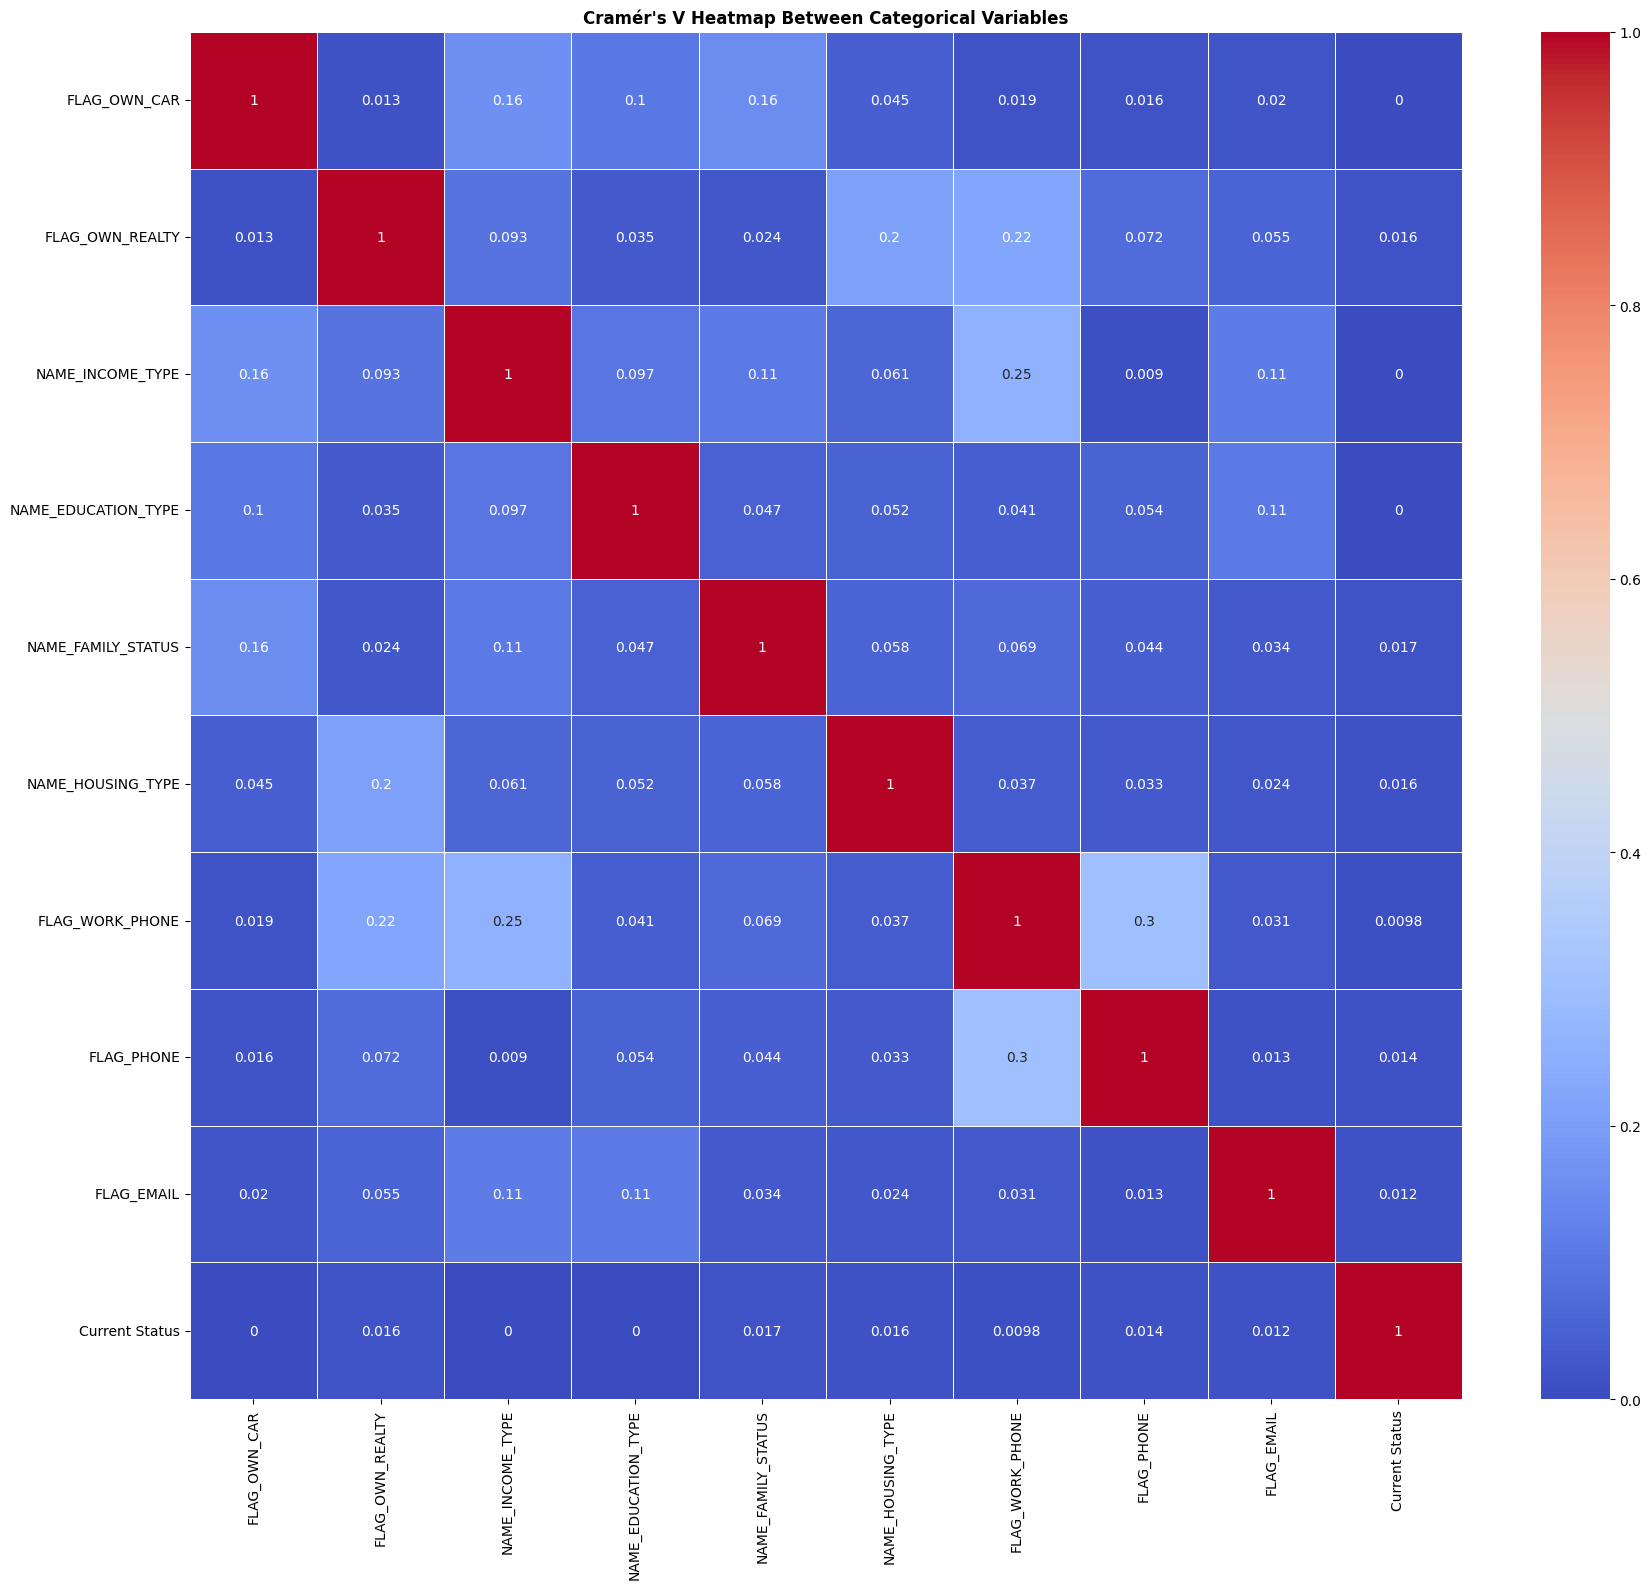

In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency

def cramers_v(x, y):
    """Compute Cramér's V statistic for two categorical vectors."""
    confusion_matrix = pd.crosstab(x, y)
    chi2, _, _, _ = chi2_contingency(confusion_matrix, correction=False)
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2_corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))  # bias correction
    r_corr = r - ((r-1)**2) / (n-1)
    k_corr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2_corr / min((k_corr-1), (r_corr-1)))

# Assuming 'categorical_features' is a DataFrame with only categorical columns
categories = categorical_features.columns
cramers_matrix = pd.DataFrame(index=categories, columns=categories, dtype=float)

# Fill the Cramér's V matrix
for col1 in categories:
    for col2 in categories:
        if col1 == col2:
            cramers_matrix.loc[col1, col2] = 1.0
        elif pd.isna(cramers_matrix.loc[col1, col2]):
            value = cramers_v(categorical_features[col1], categorical_features[col2])
            cramers_matrix.loc[col1, col2] = value
            cramers_matrix.loc[col2, col1] = value

# Plot the heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(cramers_matrix.astype(float), cmap='coolwarm', center=0.5, linewidths=0.5, annot=True)
plt.title("Cramér's V Heatmap Between Categorical Variables", fontweight='bold')
plt.tight_layout()
plt.savefig("categorical_cramersv_heatmap.svg", format="svg", bbox_inches="tight")
plt.show()


next, let's visualize the numerical features now

In [44]:
numerical_features = merged_records[['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS', 'Current Status' ]].copy()
numerical_features.head()

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,Current Status
0,0,427500.0,-12005,-4542,2.0,C
1,0,427500.0,-12005,-4542,2.0,C
2,0,112500.0,-21474,-1134,2.0,C
3,0,270000.0,-19110,-3051,1.0,0
5,0,270000.0,-19110,-3051,1.0,C


In [45]:
'''To ensure clear graphs, we need to format DAYS_BIRTH AND DAYS_EMPLOYED to be positive
not negative'''
numerical_features['DAYS_BIRTH'] = numerical_features['DAYS_BIRTH'] * -1
numerical_features['DAYS_EMPLOYED'] = numerical_features['DAYS_EMPLOYED'] * -1
numerical_features.head(30)

,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,CNT_FAM_MEMBERS,Current Status
0,0,427500.0,12005,4542,2.0,C
1,0,427500.0,12005,4542,2.0,C
2,0,112500.0,21474,1134,2.0,C
3,0,270000.0,19110,3051,1.0,0
5,0,270000.0,19110,3051,1.0,C
6,0,270000.0,19110,3051,1.0,C
8,0,283500.0,22464,-365243,1.0,0
10,0,270000.0,16872,769,2.0,0
11,0,270000.0,16872,769,2.0,X
14,0,135000.0,17778,1194,2.0,X


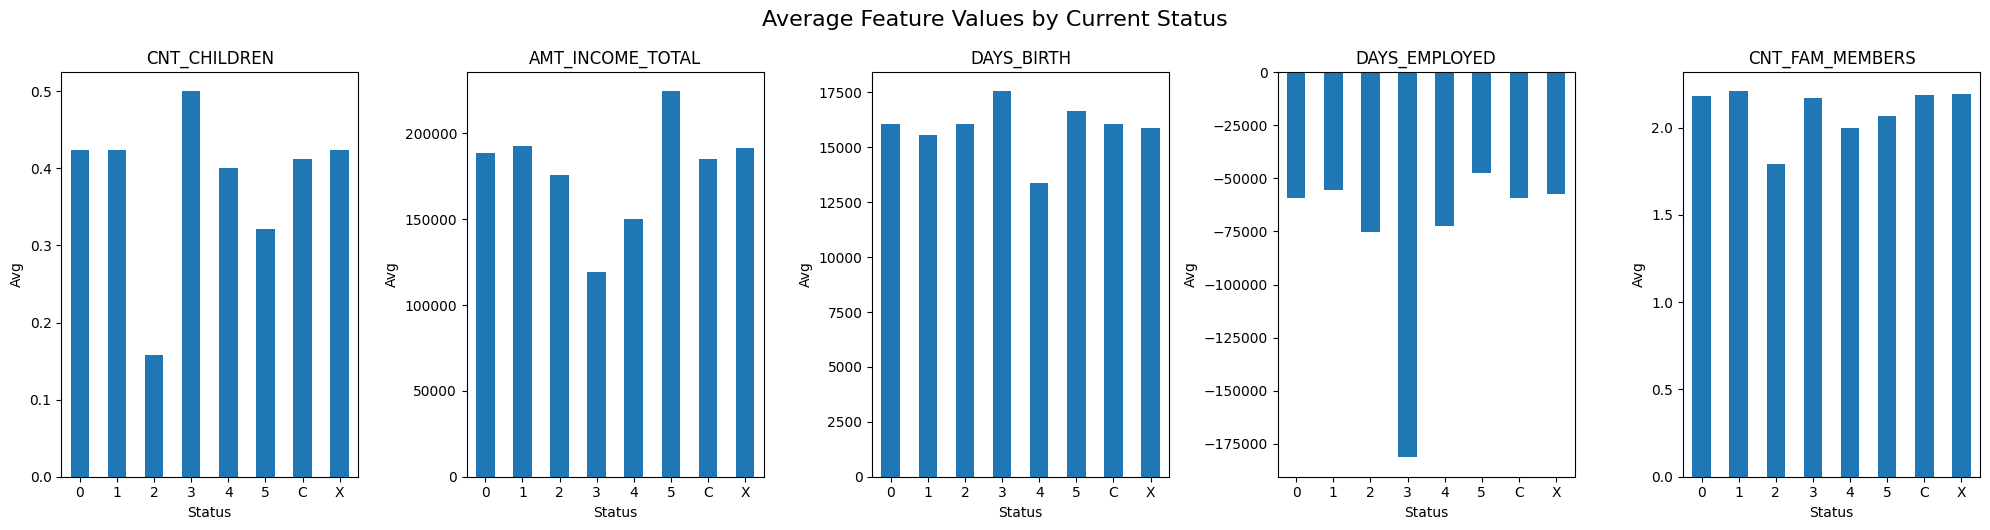

In [38]:
# List of numerical features to visualize
features = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=len(features), figsize=(20, 5))

# Generate each bar chart in a subplot
for idx, feature in enumerate(features):
    grouped = numerical_features.groupby('Current Status')[feature].mean()
    grouped.plot(kind='bar', ax=axes[idx])
    axes[idx].set_title(f'{feature}')
    axes[idx].set_xlabel('Status')
    axes[idx].set_ylabel('Avg')
    axes[idx].tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.suptitle('Average Feature Values by Current Status', fontsize=16, y=1.05)
plt.savefig("average_feature_values_by_current_status.svg", format="svg", bbox_inches="tight")
plt.show()

It's strange that the bar charts for DAYS_EMPLOYED are all in negative numbers, however, upon close inspection, it seems this is because they are averages of each Current Status, so the negative numbers offset the positive numbers in the average. Hence, the correlation ratios should be tested as well

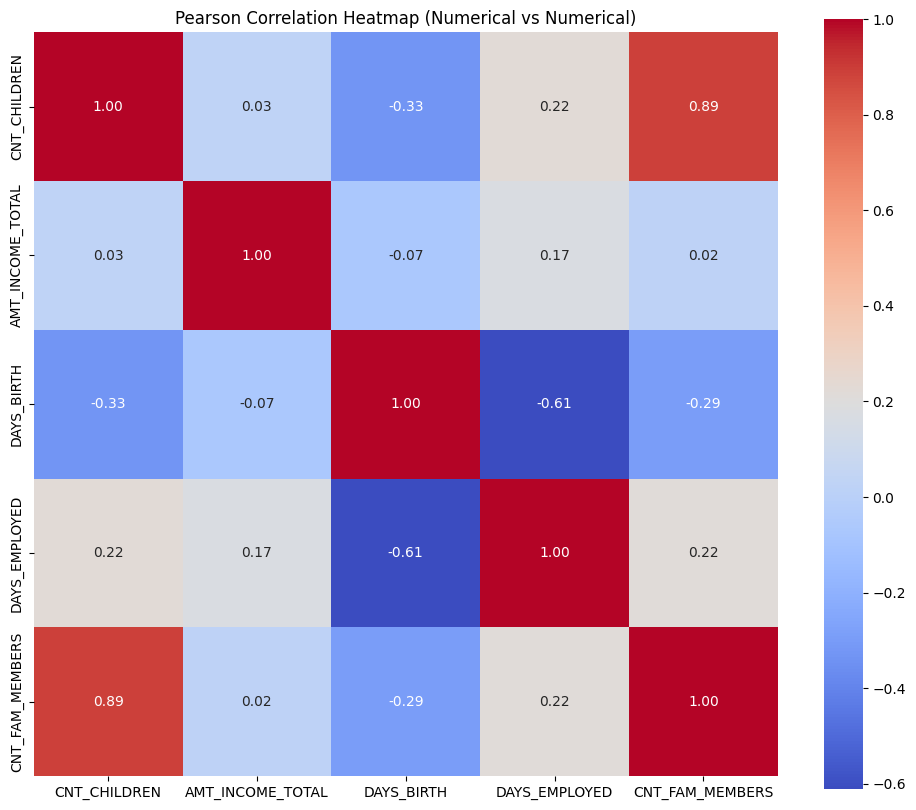

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

# Compute Pearson correlation
pearson_corr = numerical_features.corr(method='pearson')

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Pearson Correlation Heatmap (Numerical vs Numerical)")
plt.show()


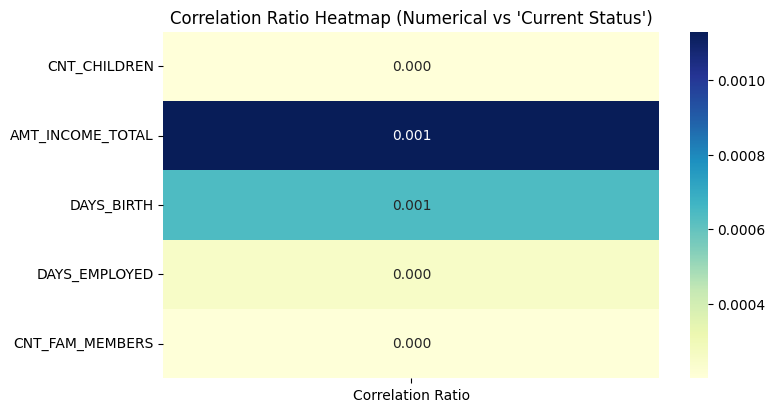

In [49]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Define correlation ratio function
def correlation_ratio(categories, measurements):
    fcat, _ = pd.factorize(categories)
    cat_num = np.max(fcat) + 1
    y_avg_array = np.zeros(cat_num)
    n_array = np.zeros(cat_num)

    for i in range(cat_num):
        cat_measures = measurements[fcat == i]
        n_array[i] = len(cat_measures)
        if len(cat_measures) > 0:
            y_avg_array[i] = np.mean(cat_measures)

    y_total_avg = np.sum(y_avg_array * n_array) / np.sum(n_array)
    numerator = np.sum(n_array * (y_avg_array - y_total_avg) ** 2)
    denominator = np.sum((measurements - y_total_avg) ** 2)

    if denominator == 0:
        return 0.0
    return numerator / denominator

# Calculate correlation ratio for each numerical feature against 'Current Status'
corr_ratios = {}
target_variable = numerical_features['Current Status']
numerical_features = numerical_features.select_dtypes(include=[np.number])
for col in numerical_features.columns:
    corr_ratios[col] = correlation_ratio(target_variable, numerical_features[col])

# Convert to DataFrame
corr_ratio_df = pd.DataFrame(corr_ratios, index=['Correlation Ratio']).T

# Plot heatmap
plt.figure(figsize=(8, len(corr_ratio_df)*0.5 + 2))
sns.heatmap(corr_ratio_df, annot=True, cmap='YlGnBu', fmt=".3f")
plt.title("Correlation Ratio Heatmap (Numerical vs 'Current Status')")
plt.show()


It would also be interesting to investigate any ordinal features, to see if they can tell a story, beyond just any correlations or associations that can be seen through heat maps

In [34]:
ordinal_features = merged_records[['AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS' ]].copy()

In [35]:
#Now, I need to add all columns from -60 to -1

#Ensure the columns are strings if they are not already
columns_to_append = [str(i) for i in range(-60, 0)]

# Append the columns (aligning by index)
ordinal_features = pd.concat([ordinal_features, merged_records[columns_to_append]], axis=1)
ordinal_features = pd.concat([ordinal_features, merged_records['Current Status']], axis=1)
ordinal_features.head(20)

,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_EMPLOYED,CNT_FAM_MEMBERS,-60,-59,-58,-57,-56,-55,-54,-53,-52,-51,-50,-49,-48,-47,-46,-45,-44,-43,-42,-41,-40,-39,-38,-37,-36,-35,-34,-33,-32,-31,-30,-29,-28,-27,-26,-25,-24,-23,-22,-21,-20,-19,-18,-17,-16,-15,-14,-13,-12,-11,-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,Current Status
0,427500.0,-12005,-4542,-4542,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,1,C,C,C,C,C,C,C,C,C,C,C,C,C
1,427500.0,-12005,-4542,-4542,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,1,C,C,C,C,C,C,C,C,C,C,C,C
2,112500.0,-21474,-1134,-1134,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,X,X,X,0,X,X,X,0,X,X,X,X,X,X,0,X,0,X,0,0,X,C,C,C,C,C,C,C
3,270000.0,-19110,-3051,-3051,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,0,X,0
5,270000.0,-19110,-3051,-3051,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,0,X,0,0,0,X,0,X,0,X,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C
6,270000.0,-19110,-3051,-3051,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,X,0,X,0,0,0,X,0,X,0,X,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C,C
8,283500.0,-22464,365243,365243,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,0,0,0,0,0,0,0,0,0,0,0,0,X,X,0
10,270000.0,-16872,-769,-769,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0
11,270000.0,-16872,-769,-769,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0,0,0,0,0,0,0,X,0,0,X,0,0,0,0,X,0,0,0,X,0,0,0,0,0,0,0,0,0,0,X,0,0,0,0,0,0,0,X,X,X
14,135000.0,-17778,-1194,-1194,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,X,0,0,0,X,0,0,0,X


Lastly, to investigate the distrubution of the Current Status's

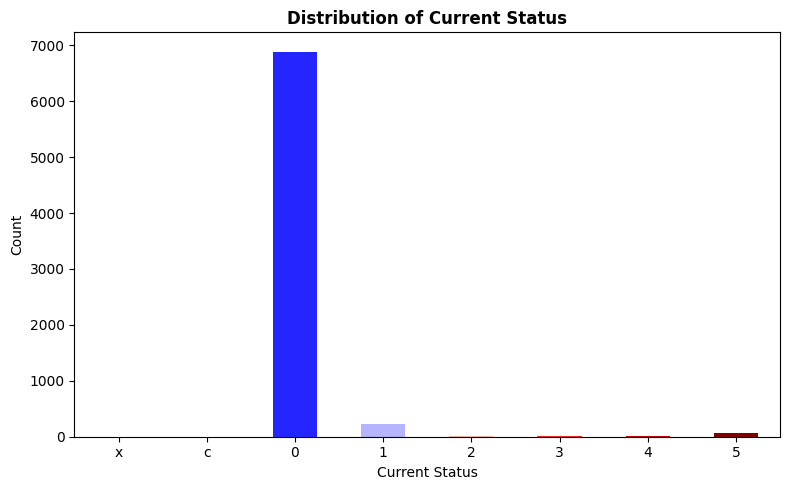

In [36]:
# Define order and apply seismic color mapping
status_order = ['x', 'c', '0', '1', '2', '3', '4', '5']
seismic_cmap = plt.colormaps.get_cmap('seismic')
colors = seismic_cmap(np.linspace(0, 1, len(status_order)))
color_map = dict(zip(status_order, colors))

# Count and reorder
counts = categorical_features['Current Status'].value_counts().reindex(status_order)
bar_colors = [color_map[status] for status in counts.index]

# Plot
plt.figure(figsize=(8, 5))
counts.plot(kind='bar', color=bar_colors)
plt.title('Distribution of Current Status', fontweight='bold')
plt.xlabel('Current Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

As expected, it shows a highly imbalanced data.

In [ ]:
'''After some trial and error, I noticed that some classes are too small to be rebalanced
using k-means SMOTE, so I have decided to reclassify the labels as 0, 1, 2, whereas
0 contains {C,X}, 1 contains {0,1,2}, 2 contains {3,4,5}'''
merged_records.to_csv('merged_records.csv',index = False)

# Define the mapping for 'Current Status'
status_map = {
    'C': 0,
    'X': 0,
    '0': 1,
    '1': 1,
    '2': 1,
    '3': 2,
    '4': 2,
    '5': 2
}

# Apply the mapping
merged_records['Current Status'] = merged_records['Current Status'].astype(str).map(status_map)
merged_records.head()

Now, it's time to transform the dataset

In [ ]:
#I need to replace all NaN values with -1, so as to show that
#this is when the client didn't have a credit card yet
merged_records = merged_records.fillna('-1')

#Before, transforming the dataset, I need to split it into training and testing sets.
#I would also stratify by Current Status, to ensure similar distributions of each class,
#for testing and training
X = merged_records.drop(columns=['Current Status'])
y = merged_records['Current Status']
X_train_set, X_test_set, Y_train_set, Y_test_set = train_test_split(X, y, test_size=0.2, stratify=y, random_state=22)

In [ ]:
merged_records['NAME_EDUCATION_TYPE'].unique()

In [ ]:
#next, I need to encode all categorical features, based on their type (ordinal vs nominal)

#Encoding Ordinal Features
#Define the order of the categories in NAME_EDUCATION_TYPE
order = [['Lower secondary', 'Secondary / secondary special', 'Incomplete higher', 'Higher education', 'Academic degree']]

encoder = OrdinalEncoder(categories=order)
X_train_set['NAME_EDUCATION_TYPE'] = encoder.fit_transform(X_train_set[['NAME_EDUCATION_TYPE']])
X_test_set['NAME_EDUCATION_TYPE'] = encoder.fit_transform(X_test_set[['NAME_EDUCATION_TYPE']])
X_train_set.head()

In [ ]:
#Obviously, Current Status should also be ordinally encoded

Y_train_set = pd.DataFrame(Y_train_set)
Y_test_set = pd.DataFrame(Y_test_set)

order = [['0', '1', '2']]

encoder = OrdinalEncoder(categories=order)
Y_train_set['Current Status'] = encoder.fit_transform(Y_train_set[['Current Status']])
Y_test_set['Current Status'] = encoder.fit_transform(Y_test_set[['Current Status']])
Y_train_set.head()

In [ ]:
cols_to_encode = [str(i) for i in range(-60, 0)]
order = [['-1','X', 'C', '0', '1', '2', '3', '4', '5']] * 60
encoder = OrdinalEncoder(categories=order)
X_train_set[cols_to_encode] = encoder.fit_transform(X_train_set[cols_to_encode])
X_test_set[cols_to_encode] = encoder.fit_transform(X_test_set[cols_to_encode])
X_train_set.head()

In [ ]:
#Encoding Nominal Features using One-Hot encoding
columns_to_encode = ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']
onehot_encoder = OneHotEncoder(sparse_output=False, drop='first')
# Separate the categorical and non-categorical columns
categorical_data = X_train_set[columns_to_encode]
other_data = X_train_set.drop(columns=columns_to_encode)

# Initialize OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, drop='first', handle_unknown='ignore')

# Fit and transform the categorical data
encoded_array = encoder.fit_transform(categorical_data)

# Create a DataFrame with the encoded feature names
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(columns_to_encode))

# Concatenate back with the other columns
X_train_set = pd.concat([encoded_df.reset_index(drop=True), other_data.reset_index(drop=True)], axis=1)
X_train_set.head()

In [ ]:
#Now, to also applying one-hot encoding on the testing set as well
# For test set: Apply the encoder fitted on training set
categorical_test_data = X_test_set[columns_to_encode]
other_test_data = X_test_set.drop(columns=columns_to_encode)

# Just transform (not fit)
encoded_test_array = encoder.transform(categorical_test_data)

# Create a DataFrame for encoded test data
encoded_test_df = pd.DataFrame(encoded_test_array, columns=encoder.get_feature_names_out(columns_to_encode))

# Combine with non-categorical features
X_test_set = pd.concat([encoded_test_df.reset_index(drop=True), other_test_data.reset_index(drop=True)], axis=1)
X_test_set.head()

In [ ]:
#Transform numerical features using min_max scaling, because it's better for KNN
X_train_set['DAYS_BIRTH'] = X_train_set['DAYS_BIRTH'] * -1
X_train_set['DAYS_EMPLOYED'] = X_train_set['DAYS_EMPLOYED'] * -1
X_test_set['DAYS_BIRTH'] = X_test_set['DAYS_BIRTH'] * -1
X_test_set['DAYS_EMPLOYED'] = X_test_set['DAYS_EMPLOYED'] * -1

# Columns to normalize
columns_to_normalize = ['CNT_CHILDREN', 'AMT_INCOME_TOTAL', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'CNT_FAM_MEMBERS']

# Initialize the scaler
scaler = MinMaxScaler()

# Apply min-max normalization
X_train_set[columns_to_normalize] = scaler.fit_transform(X_train_set[columns_to_normalize])

#View the result
print(X_train_set[columns_to_normalize].head())
X_test_set[columns_to_normalize] = scaler.transform(X_test_set[columns_to_normalize])

Now, it's time to balance the data, using K-means SMOTE, as recommended by this research paper: https://ieeexplore.ieee.org/document/9239944

In [ ]:
from sklearn.cluster import KMeans
from imblearn.over_sampling import KMeansSMOTE, RandomOverSampler
from sklearn.metrics import silhouette_score
import pandas as pd
import numpy as np

# Step 0: Check original class distribution
print("📊 Original class distribution:")
print(Y_train_set.value_counts())

# Step 1: If any class has < 3 samples, use RandomOverSampler instead
minority_counts = Y_train_set.value_counts()
if any(minority_counts < 3):
    print("⚠️ Some classes have fewer than 3 samples. Using RandomOverSampler instead of KMeansSMOTE.")
    ros = RandomOverSampler(random_state=22)
    X_resampled, y_resampled = ros.fit_resample(X_train_set, Y_train_set)
else:
    # Step 2: Find optimal k using silhouette score
    def find_optimal_k(X, min_k=2, max_k=10):
        best_k = min_k
        best_score = -1
        for k in range(min_k, max_k + 1):
            kmeans = KMeans(n_clusters=k, random_state=22, n_init=10)
            labels = kmeans.fit_predict(X)
            score = silhouette_score(X, labels)
            print(f"Silhouette score for k={k}: {score:.4f}")
            if score > best_score:
                best_k = k
                best_score = score
        return best_k

    optimal_k = find_optimal_k(X_train_set, min_k=2, max_k=10)
    print(f"✅ Best number of clusters: {optimal_k}")

    # Step 3: Apply KMeansSMOTE
    kmeans = KMeans(n_clusters=optimal_k, random_state=22, n_init=10)
    kmeans_smote = KMeansSMOTE(
        random_state=22,
        kmeans_estimator=kmeans,
        cluster_balance_threshold=0  # <-- Let it use even one minority sample per cluster
    )

    X_resampled, y_resampled = kmeans_smote.fit_resample(X_train_set, Y_train_set)

# Step 4: Show new class distribution
print("✅ Resampled class distribution:")
print(y_resampled.value_counts())

In [ ]:
X_resampled.head()

In [ ]:
#Now, it's time to create and train the KNN Model

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Initialize and train the model
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train_set, Y_train_set)

# 2. Predict on test set
y_pred_knn = knn_model.predict(X_test_set)

# 3. Evaluate
print("K-Nearest Neighbors Evaluation:")
cm_knn = confusion_matrix(Y_test_set, y_pred_knn)
print(cm_knn)
print(classification_report(Y_test_set, y_pred_knn))

# 4. Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap='coolwarm')
plt.title("KNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [ ]:
# Overwrite training set with resampled data
X_train_set = X_resampled
Y_train_set = y_resampled

# Just to be safe, reset index (optional)
if isinstance(X_train_set, pd.DataFrame):
    X_train_set.reset_index(drop=True, inplace=True)
if isinstance(Y_train_set, pd.Series):
    Y_train_set.reset_index(drop=True, inplace=True)

I will reconsider this later:
Next, we need to remove features that are strongly correlated with each other, to avoid difficulty in interpretation and overfitting the data. Try to generate 4 different heat maps, using the right correlation coefficients, as you shown in your yellow notebook

Add the other Machine Learning models below

Logistic Regression Model


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
log_reg = LogisticRegression()
log_reg.fit(X_train_set, Y_train_set)
y_pred_log_reg = log_reg.predict(X_test_set)

# Evaluate the model
print("Logistic Regression Evaluation:")
cm_log = confusion_matrix(Y_test_set, y_pred_log_reg)
print(cm_log)
print(classification_report(Y_test_set, y_pred_log_reg))

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm_log, annot=True, fmt='d', cmap='Blues')
plt.title("Logistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Decision tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train_set, Y_train_set)
y_pred_tree = decision_tree.predict(X_test_set)

print("Decision Tree Evaluation:")
cm_tree = confusion_matrix(Y_test_set, y_pred_tree)
print(cm_tree)
print(classification_report(Y_test_set, y_pred_tree))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_tree, annot=True, fmt='d', cmap='Greens')
plt.title("Decision Tree - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


SVM


In [ ]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train_set, Y_train_set)
y_pred_svm = svm_model.predict(X_test_set)

print("SVM Evaluation:")
cm_svm = confusion_matrix(Y_test_set, y_pred_svm)
print(cm_svm)
print(classification_report(Y_test_set, y_pred_svm))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Purples')
plt.title("SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Naive Bayes


In [ ]:
from sklearn.naive_bayes import GaussianNB

nb_model = GaussianNB()
nb_model.fit(X_train_set, Y_train_set)
y_pred_nb = nb_model.predict(X_test_set)

print("Naive Bayes Evaluation:")
cm_nb = confusion_matrix(Y_test_set, y_pred_nb)
print(cm_nb)
print(classification_report(Y_test_set, y_pred_nb))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Oranges')
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Ensemble Learning #1 Voting Classifier (Hard Voting)
This combines multiple base models (Logistic Regression, Decision Tree, and SVM

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression()),
        ('dt', DecisionTreeClassifier()),
        ('svc', SVC())
    ],
    voting='hard'
)

voting_clf.fit(X_train_set, Y_train_set)
y_pred_voting = voting_clf.predict(X_test_set)

print("Voting Classifier Evaluation:")
cm_vote = confusion_matrix(Y_test_set, y_pred_voting)
print(cm_vote)
print(classification_report(Y_test_set, y_pred_voting))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_vote, annot=True, fmt='d', cmap='BuPu')
plt.title("Voting Classifier - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Ensemble Learning #2 Gradient Boosting


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_set, Y_train_set)
y_pred_gb = gb_model.predict(X_test_set)

print("Gradient Boosting Evaluation:")
cm_gb = confusion_matrix(Y_test_set, y_pred_gb)
print(cm_gb)
print(classification_report(Y_test_set, y_pred_gb))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='OrRd')
plt.title("Gradient Boosting - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Ensemble Learning #3 Random Forest (Bagging-based)


In [ ]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_set, Y_train_set)
y_pred_rf = rf_model.predict(X_test_set)

print("Random Forest Evaluation:")
cm_rf = confusion_matrix(Y_test_set, y_pred_rf)
print(cm_rf)
print(classification_report(Y_test_set, y_pred_rf))

plt.figure(figsize=(6, 4))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='YlGn')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Ensemble Accuracy Comparison


In [ ]:
from sklearn.metrics import accuracy_score

# Dictionary to store model names and their accuracy
ensemble_accuracies = {}

# 1. Random Forest
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_set, Y_train_set)
y_pred_rf = rf_model.predict(X_test_set)
ensemble_accuracies['Random Forest'] = accuracy_score(Y_test_set, y_pred_rf)

# 2. Gradient Boosting
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_set, Y_train_set)
y_pred_gb = gb_model.predict(X_test_set)
ensemble_accuracies['Gradient Boosting'] = accuracy_score(Y_test_set, y_pred_gb)

# 3. Voting Classifier (Hard Voting)
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(max_iter=200)),
        ('dt', DecisionTreeClassifier()),
        ('svc', SVC())
    ],
    voting='hard'
)
voting_clf.fit(X_train_set, Y_train_set)
y_pred_voting = voting_clf.predict(X_test_set)
ensemble_accuracies['Voting Classifier'] = accuracy_score(Y_test_set, y_pred_voting)

# Display results in a DataFrame
ensemble_results_df = pd.DataFrame(
    list(ensemble_accuracies.items()), columns=['Model', 'Accuracy']
)
print(ensemble_results_df)

